# The X-files problem

#### This problem is for you to show your abilities in data loading, cleaning and descriptive analysis. Some rows contain errors. Extra points: clean these rows and include them in your analysis.

You’re at the airport, on your way to a Data Science conference abroad. A strange, but somewhat familiar man sits right next to you. He’s talking on the phone and wearing a tin hat. He briefly looks at you and turns away lowering his voice suspiciously. Although you know it isn’t right, you try to listen in on the conversation he’s having---let’s call it your scientific interest.

Strange Man: “... not a real one, no,” he says. “Do you know how rare U.F.O. sightings are?”

You: “Actually,” you interject, “it’s really simple, if you have the data.”


The old man looks at you, first alarmed and then with curiosity.

Strange Man: “Explain.”

You: “Well, with enough data you can make estimations about the probability of an event, however rare it may occur.”

Strange Man: “Can you do it?” he asks you.

You: “Of course, I’m a data scientist. I just need data.”

Strange Man: “In that case,” as the man spoke, he began rummaging through his travel bag until he pulled out a parcel covered in tinfoil. It was a shoebox filled with floppy disks.

Strange Man: “...here’s data my company, Infinito, has collected about U.F.O. sightings. People from around the world go to my company’s website and fill-out a form about their U.F.O. experience. I would like to hire you to tell me where I should go if I want to see an U.F.O. or interview people that claim sightings.”

As you take the box, still wondering where you’ll get a computer capable of reading the floppy disks, he gets up and starts to leave.

Strange Man: “Ohhhh!  I almost forgot.” he says. “Make sure you present your findings in a way my shareholders will understand. The truth may be out there... and no one is doing anything.”


## Introduction.

We will start this exercise by handling the missing values and cleaning the dataframe. Then we will conduct a geographic analysis, followed by a temporal analysis. 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
ufos = pd.read_csv('/Users/sebastianquintanilla/Downloads/ufo_sightings/UFO_sightings.csv', low_memory = False)
# Info is stored in the DataFrame 'ufos'
# We use low_memory = False to avoid warning of columns with mixed types

ufos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
datetime                80332 non-null object
city                    80332 non-null object
state                   74535 non-null object
country                 70662 non-null object
shape                   78400 non-null object
duration (seconds)      80332 non-null object
duration (hours/min)    80332 non-null object
comments                80317 non-null object
date posted             80332 non-null object
latitude                80332 non-null object
longitude               80332 non-null float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


We can see that the data types of most columns is object (except for longitude that is a float). Notice that the columns with missing entries are state, country, shape and comments.
Lastly, we realize we have two columns for the duration of the sighting. We drop the second one, since having that information in seconds is easier to handle.

In [10]:
ufos.drop('duration (hours/min)',axis=1, inplace = True)

ufos['latitude'] = pd.to_numeric(ufos['latitude'], errors='coerce')
ufos['datetime'] = pd.to_datetime(ufos['datetime'], errors='coerce')
ufos.rename(columns={'longitude ':'longitude'}, inplace = True)

ufos.info()

Now the columns datetime and latitude have also missing values (1 and ~700) because of the change of data type. Next we can see the amount of missing entries in each of the columns.

In [15]:
missing = ufos.isnull().sum()
print(missing.sort_values(ascending=False))

country               9670
state                 5797
shape                 1932
datetime               694
comments                15
latitude                 1
longitude                0
date posted              0
duration (seconds)       0
city                     0
dtype: int64


Most of our missing data is geographic, around 12% of rows don't have the country and 7% don't have the state information. Also the shape information is missing in 2%, but in this data (as  with the comments) we don't have much problem with missing values. Lastly, we will ignore the missing values in our datetime data since it is a bit less than 1%.

## 1. Geographic Analysis.

In [53]:
ufos['country'].fillna('?', inplace = True)
ufos.groupby('country').size().sort_values(ascending = False)

country
us    65114
?      9670
ca     3000
gb     1905
au      538
de      105
dtype: int64

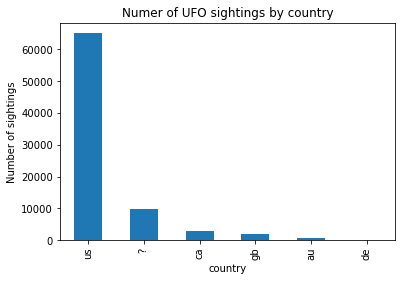

In [81]:
ufos['country'].value_counts().plot(kind = 'bar')
plt.xlabel('country')
plt.ylabel('Number of sightings')
plt.title('Numer of UFO sightings by country')
plt.show()

Our data has 5 declared countries, United States of America (us), Canada (ca), Great Britain (gb), Australia (au) and Germany (de). We marked the missing values with "?". 

Most of the sightings (81%) come from the U.S., followed by the missing values. Before we take care of the missing geographic info we wil plot the coordinates (longitude and latitude) of all the sightings, and then of all the sightings with missing country info, to see where are those sightings located.

Because the U.S. is the country with the most sightings we will see which state is where most UFOs are seen.

In [84]:
n = len(ufos[ufos['country']=='us'])
ufos[ufos['country']=='us'].groupby(['country','state']).size().sort_values(ascending=False)/n

country  state
us       ca       0.136868
         wa       0.060909
         fl       0.058897
         tx       0.052938
         ny       0.045766
         il       0.038379
         az       0.037073
         pa       0.036336
         oh       0.034939
         mi       0.028197
         or       0.026830
         nc       0.026722
         mo       0.022391
         co       0.021700
         in       0.019781
         va       0.019550
         ma       0.019289
         nj       0.019274
         ga       0.019274
         wi       0.018921
         tn       0.017185
         mn       0.015542
         sc       0.015404
         ct       0.013699
         ky       0.013131
         md       0.012854
         nv       0.012332
         ok       0.011119
         nm       0.011058
         ia       0.010413
         al       0.009860
         ut       0.009552
         ks       0.009414
         ar       0.009030
         me       0.008570
         la       0.008570
         id  

13.7% of sightings in the U.S. happened in the state of California. That is more than double the sighting of the runner-up states Washington (6.1%), Florida (5.9%) and Texas (5.3%).

Given that 81% of the sightings were in the U.S., 10% of all the reported sightings were in the state of California, which is very impressive.

## 2. Temporal Analysis.

We will now analyze in which time do the sightings occur. We will begin by looking at the decade they occurred.

In [45]:
def decade(row):
    '''This function returns the hour the sighting happened given its datetime info
    '''
    try:
        row['decade'] = int(row['datetime'].year/10)*10
    except:
        pass
    return row
ufos = ufos.apply(decade, axis=1)

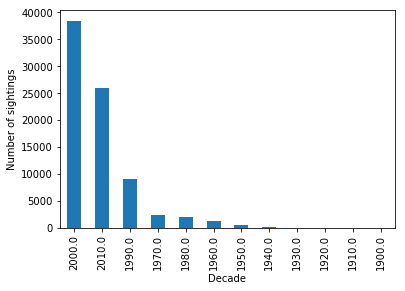

In [51]:
ufos['decade'].value_counts().plot(kind = 'bar')
plt.xlabel('Decade')
plt.ylabel('Number of sightings')
plt.show()

Most UFO sightings happened in the 2000's and 2010's (the 2010's have less data because this database ends in 2014). Maybe recently more UFOs have visited our planet and that is why there have been much more sightings in the last two decades, but it seems more reasonable to assume that more sightings are reported recently only because now it is easier to gather this information.

So we will assume that the decade has no influence in the number of sightings (although it is curious to notice that the 70's had more sightings than the 80's).

In [25]:
def hour(row):
    '''This function returns the hour the sighting happened given its datetime info
    '''
    row['hour'] = row['datetime'].hour
    return row

ufos = ufos.apply(hour, axis=1)

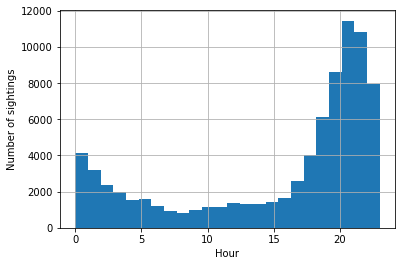

In [50]:
ufos['hour'].hist(bins=24)
plt.xlabel('Hour')
plt.ylabel('Number of sightings')
plt.show()

We can see that the most UFOs sighting happen at night, between 18:00 and 24:00. This could be because UFOs are mostly visible when the sun is not around, and after midnight most people are asleep or inside their houses, where they cannot see UFOs. Or maybe, this are the most common hours to see an UFO because those are the best hours for aliens to visit our planet.

Either way, it looks like the best time to look for UFOs is between 18:00 and 24:00.

Now we will investigate if the season of the year has an influence in the sightings.

In [33]:
def season(row):
    ''' This function tells us the season the sighting happened, taking into account 
    the hemisphere (latitude > 0 is northern hemisphere)
    '''
    if row['latitude'>0]:
        if 3 <= row['datetime'].month < 6:
            row['season'] = 'Spring'
        elif 6 <= row['datetime'].month <9:
            row['season'] = 'Summer'
        elif 9 <= row['datetime'].month <12:
            row['season'] = 'Autumn'
        else:
            row['season'] = 'Winter'
    else:
        if 3 <= row['datetime'].month < 6:
            row['season'] = 'Autumn'
        elif 6 <= row['datetime'].month <9:
            row['season'] = 'Winter'
        elif 9 <= row['datetime'].month <12:
            row['season'] = 'Spring'
        else:
            row['season'] = 'Summer'
    return row

ufos = ufos.apply(season, axis=1)        

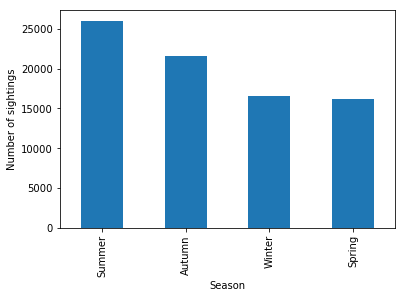

In [52]:
ufos['season'].value_counts().plot(kind = 'bar')
plt.xlabel('Season')
plt.ylabel('Number of sightings')
plt.show()

UFOs are seen all around the year, but according to the data it is more likely to see one on Summer than on the other seasons. Maybe more sightings have happened on summer because people are more likely to be out at night on warmer days, or because the skies are clearer on summer.

## 3. Conclusion.

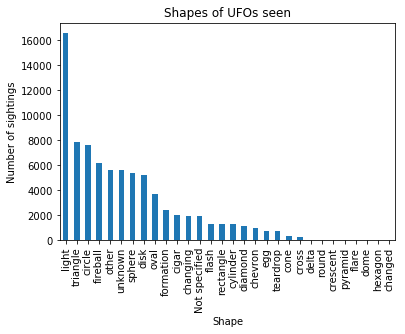

In [55]:
ufos['shape'].fillna('Not specified', inplace = True)
ufos['shape'].value_counts().plot(kind = 'bar')
plt.xlabel('Shape')
plt.ylabel('Number of sightings')
plt.title('Shapes of UFOs seen')
plt.show()

The most popular shape is described as "light", with triangular and circular shape following in 2nd and 3rd place with half as many times seen. We conclude that if you are looking for a UFO, you should be looking to the sky at around 21:00 in summer, in the U.S., searching for something with a light. This way you will maximize your chances of seeing a UFO.

## 4. Bonus (adding geographic data).

From the locations of all the UFO sightings (below) we can see the outline of an earth map. We see most of the sightings ocurred in the U.S., in the south of Canada and in Europe, but some sightings are located all around the world.

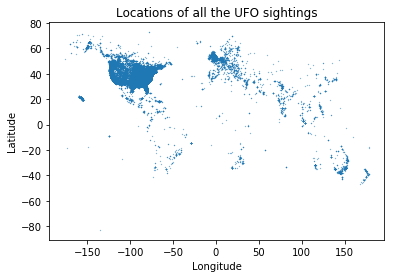

In [56]:
ufos.plot.scatter(x = 'longitude', y = 'latitude', s=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations of all the UFO sightings')
plt.show()

We can see that many of the UFO sightings without 'country' information are located in the U.S., England and Germany. We will try to add the country information to the sightings that occur in those already informed countries.

For this we will use the package geopy, and its function that returns an address given the coordinates of the place (latitude and longitude), since we have this information for evey sighting.

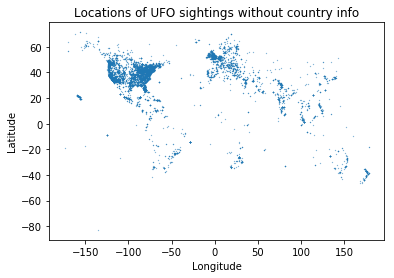

In [57]:
ufos[ufos['country']=='?'].plot.scatter(x = 'longitude', y = 'latitude', s=0.05)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations of UFO sightings without country info')
plt.show()

In [76]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")


def country(row):
    '''this function returns the country code given a row of a dataset that has latitude and longitde
    '''
    if row['country'] == '?':
        loc = geolocator.reverse([row['latitude'], row['longitude']])
        row['country'] = loc.raw['address']['country_code'].encode('utf-8') 
    return row

This function works, but it was hard to use it for the whole data set, because the geolocator can only be used at most once every second (for the 10 rows without country this would take at least 2.7 hours). And this is why I couldn't do it, but I tried it for the head() of the dataframe and it works.

In the second row of the dataframe ufos the country is missing, where it should say "us".

In [77]:
ufos.head()

,city,comments,country,date posted,datetime,decade,duration (seconds),hour,latitude,longitude,season,shape,state
0,san marcos,This event took place in early fall around 194...,us,4/27/2004,1949-10-10 20:30:00,1940.0,2700,20.0,29.883056,-97.941111,Autumn,cylinder,tx
1,lackland afb,1949 Lackland AFB&#44 TX. Lights racing acros...,?,12/16/2005,1949-10-10 21:00:00,1940.0,7200,21.0,29.384210,-98.581082,Autumn,light,tx
2,chester (uk/england),Green/Orange circular disc over Chester&#44 En...,gb,1/21/2008,1955-10-10 17:00:00,1950.0,20,17.0,53.200000,-2.916667,Autumn,circle,NaN
3,edna,My older brother and twin sister were leaving ...,us,1/17/2004,1956-10-10 21:00:00,1950.0,20,21.0,28.978333,-96.645833,Autumn,circle,tx
4,kaneohe,AS a Marine 1st Lt. flying an FJ4B fighter/att...,us,1/22/2004,1960-10-10 20:00:00,1960.0,900,20.0,21.418056,-157.803611,Autumn,light,hi


When we apply the function we see the second row country has been filled with "us".

In [79]:
ufos.head().apply(country, axis=1)

,city,comments,country,date posted,datetime,decade,duration (seconds),hour,latitude,longitude,season,shape,state
0,san marcos,This event took place in early fall around 194...,us,4/27/2004,1949-10-10 20:30:00,1940.0,2700,20.0,29.883056,-97.941111,Autumn,cylinder,tx
1,lackland afb,1949 Lackland AFB&#44 TX. Lights racing acros...,us,12/16/2005,1949-10-10 21:00:00,1940.0,7200,21.0,29.384210,-98.581082,Autumn,light,tx
2,chester (uk/england),Green/Orange circular disc over Chester&#44 En...,gb,1/21/2008,1955-10-10 17:00:00,1950.0,20,17.0,53.200000,-2.916667,Autumn,circle,NaN
3,edna,My older brother and twin sister were leaving ...,us,1/17/2004,1956-10-10 21:00:00,1950.0,20,21.0,28.978333,-96.645833,Autumn,circle,tx
4,kaneohe,AS a Marine 1st Lt. flying an FJ4B fighter/att...,us,1/22/2004,1960-10-10 20:00:00,1960.0,900,20.0,21.418056,-157.803611,Autumn,light,hi
